# Assignment-3

## Question-1 : Problem of anomaly detection

**Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import copy
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

### Part-1: PCA

- Standardize the data.

- Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix.


- Sort eigenvalues in descending order

- Choose the 𝑘 eigenvectors that correspond to the 𝑘 largest eigenvalues where 𝑘 is the number of dimensions of the new feature subspace choosen using the **knee method** to have a tolerance of 10% error.

- Construct the projection matrix 𝐖 from the selected 𝑘 eigenvectors.

- Transform the original dataset 𝐗 via 𝐖 to obtain a 𝑘-dimensional feature subspace 𝐘.

In [3]:
def pca():
    data=pd.read_csv("data.csv").values
    X=data[:,0:29]
    Y=data[:,29]
    X = np.array(X, dtype=np.float64)
    X=(X-X.mean(axis=0))/(X.std(axis=0))
    meanVector=np.mean(X, axis=0)
    n=X.shape[0]-1 #actually this is n-1
    covarianceMat=(X-meanVector).T.dot((X-meanVector))/n
    eigVals,eigVecs=np.linalg.eig(covarianceMat)
    totalEValues=len(eigVals)
    EvalueVectorPairs=[(np.abs(eigVals[x]),eigVecs[:,x]) for x in range(totalEValues)]
    EvalueVectorPairs.sort()
    EvalueVectorPairs.reverse()
    total=0
    for i in EvalueVectorPairs:
        total+=i[0]
    k=0
    ans=0
    for i in EvalueVectorPairs:
        if ans>0.9:
            break
        ans+=i[0]/total
        k+=1
    final=[]
    for i in range(k):
        final.append(EvalueVectorPairs[i][1].reshape(29,1))
    matrix_w = np.hstack(final)

    reducedFeatures=X.dot(matrix_w)
    return (k,reducedFeatures,Y)
  
  

In [4]:
print("Reduced Dimensions:  ",pca()[0])

Reduced Dimensions:   14


### Part-2 : K-Means Clustering on reduced dimensions

Our algorithm works as follows, assuming we have inputs $x_1, x_2, x_3, ..., x_nx$
and value of $K$.

Step 1 - Pick $K$ random points as cluster centers called centroids.

Step 2 - Assign each $x_i$ to nearest cluster by calculating its distance to each centroid.

Step 3 - Find new cluster center by taking the average of the assigned points.

Step 4 - Repeat Step 2 and 3 until none of the cluster assignments change.

In [0]:
# Euclidean Distance
def distance(x,y,ax=1):
    return np.linalg.norm(x - y, axis=ax)

In [1]:
def KMeans(k,forgraph=False):
    data=pca()
    dimensions=data[0]
    X=data[1]
    X=(X-X.mean(axis=0))/(X.std(axis=0))
    Y=data[2]
    count=0
    cc=[]
    for i in range(k):
        centroid=np.random.random_sample(dimensions)
        cc.append(centroid)
    newCentroids=np.array(cc)
    oldCentroids=np.zeros(newCentroids.shape)
    clusterMap=np.zeros(len(X))
    error=distance(newCentroids,oldCentroids,None)
#     print(error)
    count=0
    clusterPoints={}
    while error>0.01:
#         print(count)
        for i in range(len(X)):
            dist=distance(X[i],newCentroids)
            clusterMap[i]=np.argmin(dist)
        oldCentroids=copy.deepcopy(newCentroids)
    # Finding the new centroids by taking the average value
        for i in range(k):
            points=[]
            indexes=[]
            for j in range(len(X)):
                if clusterMap[j]==i:
                    points.append(X[j])
                    indexes.append(j)
#             points=[X[j] for j in range(len(X)) if clusterMap[j]==i]
#             print("da ",len(points))
            if len(points)>0:
                newCentroids[i]=np.mean(points,axis=0)
            clusterPoints[i]=indexes
        error=distance(newCentroids,oldCentroids,None)
#         print(error)
        count+=1
    methodPurity=0
    graphLabels=[]
    graphClusters=[]
    for key in clusterPoints.keys():
        indexes=clusterPoints[key]
        labels=np.array([ Y[index] for index in indexes])
        uniq,counts=np.unique(labels,return_counts=True)
        countIndex=np.argmax(counts)
        methodPurity+=counts[countIndex]
        if forgraph:
          graphLabels.append(uniq[countIndex]+" : "+str(counts[countIndex]/len(indexes)))
          graphClusters.append(len(indexes))
          continue
        print("========================================")
        print("Cluster: ",key+1)
        print("========================================")
        print("%10s || %2s "%("class","count"))
        print("________________________")
        for a,b in zip(uniq,counts):
          print("%10s || %2s "%(a,b))
        print()
        print("Max class '%s' with purity %s . "%(uniq[countIndex],counts[countIndex]/len(indexes)))
        print("========================================")
    if forgraph:
      return (methodPurity/len(X),graphLabels,graphClusters)
 
    print("Method clustering Purity= ",methodPurity/len(X))
    
  

In [8]:
KMeans(5)

Cluster:  1
     class || count 
________________________
       dos || 1367 
    normal || 437 
     probe || 549 
       r2l || 10 

Max class 'dos' with purity 0.5785019043588658 . 
Cluster:  2
     class || count 
________________________
       dos || 911 
    normal || 11232 
     probe || 419 
       r2l || 123 
       u2r || 10 

Max class 'normal' with purity 0.884757778653013 . 
Cluster:  3
     class || count 
________________________
       dos || 34 
    normal || 1156 
     probe || 698 
       r2l ||  3 

Max class 'normal' with purity 0.6113167636171338 . 
Cluster:  4
     class || count 
________________________
       dos || 6787 
    normal || 113 
     probe || 71 
       r2l || 54 

Max class 'dos' with purity 0.9661209964412811 . 
Cluster:  5
     class || count 
________________________
       dos || 15 
    normal || 426 
     probe || 576 
       r2l ||  7 

Max class 'probe' with purity 0.5625 . 
Method clustering Purity=  0.8447875830066406


### Part-3 : Gaussian Mixture Model

Based on Gaussian Distribution.

$$\mathcal{N}(x | \mu, \Sigma) = \frac{1}{(2\pi)^{1/2}}\frac{1}{|\Sigma|^{1/2}}exp\{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\}$$

The Guassian Mixture distribution is a linear superposition of Guassians: 

$$p(x) = \Sigma^K_{k=1}\pi_k\mathcal{N}(x|\mu_k,\Sigma_k)$$

Subject to:
$$\Sigma^K_{k=1}\pi_k = 1$$

$\pi_1...\pi_k$, the mixture weights of the components

$\mu_1...\mu_k$, the mean of each component

$\Sigma_1...\Sigma_k$, the variance of each component

We can generate samples $s_1,s_2...s_n$ from the distribution.

Maximum likelihood maximizes:
$$lnp(X|\pi,\mu,\Sigma)=\Sigma^N_{n=1}ln\{\Sigma^K_{k=1}\pi_k
\mathcal{N}(x_n|\mu_k,\Sigma_k)\}$$

In [5]:
def gMM(k,forgraph=False):
    data=pca()
    dimensions=data[0]
    X=data[1]
    Y=data[2]
    gmm = GaussianMixture(n_components = k)
    gmm.fit(X)
    labels=gmm.predict(X) 
    labelsDict={}
    for index,label in enumerate(labels):
        labelsDict.setdefault(label,[]).append(index)
    methodPurity=0
    graphLabels=[]
    graphClusters=[]
    for key in labelsDict.keys():
        indexes=labelsDict[key]
        labelss=np.array([Y[index] for index in indexes])
        uniq,counts=np.unique(labelss,return_counts=True)
        countIndex=np.argmax(counts)
        methodPurity+=counts[countIndex]
        if forgraph:
          graphLabels.append(uniq[countIndex]+" : "+str(counts[countIndex]/len(indexes)))
          graphClusters.append(len(indexes))
          continue
        print("========================================")
        print("Cluster: ",key+1)
        print("========================================")
        print("%10s || %2s "%("class","count"))
        print("________________________")
        for a,b in zip(uniq,counts):
          print("%10s || %2s "%(a,b))
        print()
        print("Max class '%s' with purity %s . "%(uniq[countIndex],counts[countIndex]/len(indexes)))       
        print("========================================")
    if forgraph:
      return (methodPurity/len(X),graphLabels,graphClusters)
    print("Method clustering Purity= ",methodPurity/len(X))

In [6]:
gMM(5)

Cluster:  4
     class || count 
________________________
       dos || 2106 
    normal || 5589 
     probe || 1376 
       r2l || 89 

Max class 'normal' with purity 0.6101528384279477 . 
Cluster:  3
     class || count 
________________________
       dos || 645 
    normal || 6613 
     probe || 93 
       r2l || 17 
       u2r ||  3 

Max class 'normal' with purity 0.8971645638312304 . 
Cluster:  2
     class || count 
________________________
       dos || 6164 

Max class 'dos' with purity 1.0 . 
Cluster:  5
     class || count 
________________________
       dos || 17 
    normal || 475 
     probe || 289 
       r2l || 22 

Max class 'normal' with purity 0.5915317559153176 . 
Cluster:  1
     class || count 
________________________
       dos || 182 
    normal || 687 
     probe || 555 
       r2l || 69 
       u2r ||  7 

Max class 'normal' with purity 0.458 . 
Method clustering Purity=  0.781182494599568


### Part-4: Heirarchical Clustering and Pie chart comparision between clustering methods


**Used agglomerative heirarchical clustering**

A "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.

In [0]:
def heirarchical(k,forgraph=False):
    data=pca()
    dimensions=data[0]
    X=data[1]
    Y=data[2]
    aglo = AgglomerativeClustering(linkage="single", n_clusters=k)
    aglo.fit(X)
    labels=aglo.labels_
#     print((labels))
    labelsDict={}
    for index,label in enumerate(labels):
        labelsDict.setdefault(label,[]).append(index)
    methodPurity=0
    graphLabels=[]
    graphClusters=[]
    for key in labelsDict.keys():
        indexes=labelsDict[key]
        labelss=np.array([Y[index] for index in indexes])
        uniq,counts=np.unique(labelss,return_counts=True)
        countIndex=np.argmax(counts)
        methodPurity+=counts[countIndex]
        if forgraph:
          graphLabels.append(uniq[countIndex]+" : "+str(counts[countIndex]/len(indexes)))
          graphClusters.append(len(indexes))
          continue
        print("========================================")
        print("Cluster: ",key+1)
        print("========================================")
        print("%10s || %2s "%("class","count"))
        print("________________________")
        for a,b in zip(uniq,counts):
          print("%10s || %2s "%(a,b))
        print()
        print("Max class '%s' with purity %s . "%(uniq[countIndex],counts[countIndex]/len(indexes)))
        print("========================================")
    if forgraph:
      return (methodPurity/len(X),graphLabels,graphClusters)
    print("Method clustering Purity= ",methodPurity/len(X))

In [12]:
heirarchical(5)

Cluster:  1
     class || count 
________________________
       dos || 9114 
    normal || 13360 
     probe || 2312 
       r2l || 193 
       u2r || 10 

Max class 'normal' with purity 0.5346352395053824 . 
Cluster:  3
     class || count 
________________________
    normal ||  2 
       r2l ||  4 

Max class 'r2l' with purity 0.6666666666666666 . 
Cluster:  5
     class || count 
________________________
    normal ||  1 

Max class 'normal' with purity 1.0 . 
Cluster:  4
     class || count 
________________________
    normal ||  1 

Max class 'normal' with purity 1.0 . 
Cluster:  2
     class || count 
________________________
     probe ||  1 

Max class 'probe' with purity 1.0 . 
Method clustering Purity=  0.5347227778222258


###Pie chart comparing purity of different clustering methods

Pie chart comparing purity of KNN,GMM, and herirchical along with resp. clusters purity


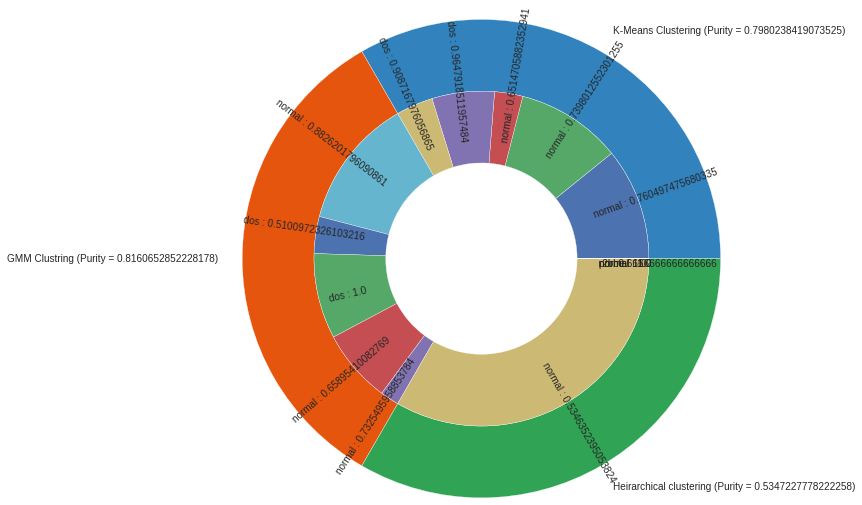

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
km=KMeans(5,True)
gm=gMM(5,True)
heir=heirarchical(5,True)

size = 0.6
labels1=["K-Means Clustering (Purity = "+str(km[0])+")","GMM Clustring (Purity = "+str(gm[0])+")","Heirarchical clustering (Purity = "+str(heir[0])+")"]
vals = np.array([km[2], gm[2], heir[2]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
# inner_colors = cmap(np.array([1,2,3,4,5,8,9,10,11,12,15,16,17,18,19]))
labels2=km[1]+gm[1]+heir[1]
# print(vals)
# print(labels1)
# print(labels2)

ax.pie(vals.sum(axis=1), radius=2, colors=outer_colors,wedgeprops=dict(width=size, edgecolor='w'),labels=labels1)

# plt.figure(figsize=(30,30))
print("Pie chart comparing purity of KNN,GMM, and herirchical along with resp. clusters purity")
ax.pie(vals.flatten(),rotatelabels=True,labeldistance=0.7,radius=2-size,wedgeprops=dict(width=size, edgecolor='w'),labels=labels2)
plt.show()

### Part-5: Does pca work on categorical data?

Basically, PCA finds and eliminate less informative (duplicate) information on feature set and reduce the dimension of feature space. In other words, imagine a N-dimensional hyperspace, PCA finds such M (M < N) features that the data variates most. In this way data may be represented as M-dimensional feature vectors. Mathematically, it is some-kind of a eigen-values & eigen vectors calculation of a feature space.

So, it is not important whether the features are continuous or discrete(categorical).

The main challenge with categorical variables is to find a suitable way to represent distances between variable categories and individuals in the factorial space. To overcome this problem, you can look for a non-linear transformation of each variable--whether it be nominal, ordinal, polynomial, or numerical--with optimal scaling. 